<a href="https://colab.research.google.com/github/adgregory/adsmovil/blob/main/CTR_Prueba_Tecnica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='orange'>State of the Art</font>

1. Deep Interest Network for Click-Through Rate Prediction
https://sci-hub.hkvisa.net/10.1145/3219819.3219823

Features y modelos implementados

2. DataSet de Kaggle. Features implementados.
https://www.kaggle.com/c/avazu-ctr-prediction/overview

# <font color='orange'>Install required libraries</font>

In [2]:
%%capture
!pip install tensorflow_data_validation

# <font color='orange'>Libraries</font>

In [248]:
# General
import pandas as pd
import numpy as np
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_data_validation as tfdv
from sklearn import tree

# Encoding
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Tree models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Non linear models
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# DNN
import tensorflow as tf

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [480]:
# Set graphs style
sns.set_theme()

# <font color='orange'>Data Understanding, Cleaning and Preprocessing</font>

## <font color='green'>Data Helper Functions</font>

In [2]:
def plot_feature_histogram(tfdv_stats, ft_idx):
  '''
  Plot histogram of specific feature from TFDV object
  -----
  Args:
       tfdv_stats: TensorFlow Data Visualization Object
       ft_idx: Index used to return the required visualization data
  ----
  '''
  hist_df = pd.DataFrame(columns=['name', 'frequency'])
  for value in tfdv_stats.datasets[0].features[ft_idx].string_stats.top_values:
    hist_df = hist_df.append({'name': value.value, 'frequency': value.frequency}, ignore_index = True)

  # Graficar Feature Histogram
  ft_name = ctr_stats.datasets[0].features[ft_idx].path.step[0]
  sns.histplot(hist_df, x = 'name', y = 'frequency')
  plt.title(ft_name + ' feature histogram')
  plt.xticks(rotation=90)


In [398]:
def delete_unknown_from_list(df, feature, unknown_list):
  '''
  Helper function to delete unknown values from feature vector.
  -----
  Args:
       df: Pandas DataFrame.
       feature: feature name.
       unknown_list: list that contains unique unknown values
  -----
  Return:
         df: Subset of original DataFrame without unknown values
  '''
  
  for unknown in unknown_list:
    df = df[df[feature] != unknown]
  return df

In [444]:
def train_test_val_split(encoded_in_df, train_frac):
  '''
  Function to split the dataset into train, test and val sets
  ----
  Args:
       encoded_df: dataframe with encoded categorical columns
       train_frac: fraction of training used
  ----
  Return:
       X_train, y_train, X_test, X_val, y_test, y_val
  '''
  
  encoded_df = encoded_in_df.copy()

  # Get X and y for training 
  X = encoded_df.drop(columns=['ctr']).to_numpy()
  # Create Scaler object for Min Max Scaling transformation
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)


  # K fold ctr scores. This is used in the next cell to well organize the dataset splits.
  y = encoded_df['ctr'].to_numpy()
  samples_per_bin, bins, = np.histogram(y)
  encoded_df['y_bin'] = np.digitize(y,bins)
  y_df = encoded_df[['ctr', 'y_bin']]

  # The split is stratified using the folds (bins) found previously
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_df, train_size = train_frac, stratify=y_df['y_bin'])
  y_train = y_train.to_numpy()[:,0]
  y_test  = y_test.to_numpy()[:,0]
  # Using the same distribution from the test set, the val set is found.
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = 0.5)

  return X_train, y_train, X_test, X_val, y_test, y_val

## <font color='green'>Data Understanding</font>

In [490]:
# Read CSV file with dataset
ctr_df = pd.read_csv('Base_proyecto.csv')
ctr_df.head()

,id,ad_position,ad_size,hour_of_day_utc,inventory_source,platform_bandwidth,environment_type,platform_carrier,app_bundle,domain,clicks,impressions,ctr
0,1,FULLSCREEN,320x480,21,UNITY,WIFI,APP,-1,Other,UNKNOWN,6,29,0.206897
1,2,FULLSCREEN,320x480,23,UNITY,WIFI,APP,-1,com.wordgame.puzzle.board.es,UNKNOWN,13,86,0.151163
2,3,0,320x480,23,OPERA_MEDIA,CELL_3G,APP,Claro,com.jamendoandoutly.mainpakkage,UNKNOWN,0,11,0.000000
3,4,FULLSCREEN,320x480,23,MOPUB,CELL_4G,APP,Movistar,com.drilens.wamr,UNKNOWN,0,38,0.000000
4,5,0,320x480,5,OPERA_MEDIA,WIFI,APP,Movistar,com.jam.endo,UNKNOWN,0,19,0.000000


Taking into account the columns of 'clicks' and 'impressions', the calculation of 'ctr' is performed and it is corroborated that the given values of ctr (with 16 decimal precision) match with the established division.

In [517]:
filtered_df = pd.DataFrame()
filtered_df['clicks'] = ctr_df['clicks']
filtered_df['impressions'] = ctr_df['impressions']

filtered_df['ctr_calculated'] = np.round(np.float64(filtered_df['clicks']/filtered_df['impressions']), 17)

In [518]:
filtered_df['ctr_calculated'] = filtered_df['ctr_calculated'].astype(str)

In [519]:
new_val = []
for val in filtered_df['ctr_calculated']:
  if len(val) == 19:
    val = val[:-1]
  new_val.append(np.float(val))
filtered_df['ctr_calculated'] = new_val

In [520]:
filtered_df['ds_ctr'] = ctr_df['ctr']
filtered_df['comparision'] = list(filtered_df['ctr_calculated'] == ctr_df['ctr'])

In [521]:
filtered_df[filtered_df['comparision'] == False]

,clicks,impressions,ctr_calculated,ds_ctr,comparision
41,4,109,0.036697,0.036697,False
54,3,103,0.029126,0.029126,False
504,2,93,0.021505,0.021505,False
537,2,111,0.018018,0.018018,False
761,1,455,0.002198,0.002198,False
...,...,...,...,...,...
26335,3,1083,0.002770,0.002770,False
26491,1,127,0.007874,0.007874,False
31236,5,6,0.833333,0.833333,False
31904,5,6,0.833333,0.833333,False


As shown above, 261 CTR values do not match. By inspecting the results, it was found that the mismatch was due to float precision. Therefore, no CTR rows will be removed.

Since CTR = clicks/impressions, our model cannot use these features as inputs. Here the id columns is also deleted.

In [104]:
ctr_df.drop(columns = ['id', 'clicks', 'impressions'], inplace = True)

In [105]:
ctr_df.head()

,ad_position,ad_size,hour_of_day_utc,inventory_source,platform_bandwidth,environment_type,platform_carrier,app_bundle,domain,ctr
0,FULLSCREEN,320x480,21,UNITY,WIFI,APP,-1,Other,UNKNOWN,0.206897
1,FULLSCREEN,320x480,23,UNITY,WIFI,APP,-1,com.wordgame.puzzle.board.es,UNKNOWN,0.151163
2,0,320x480,23,OPERA_MEDIA,CELL_3G,APP,Claro,com.jamendoandoutly.mainpakkage,UNKNOWN,0.000000
3,FULLSCREEN,320x480,23,MOPUB,CELL_4G,APP,Movistar,com.drilens.wamr,UNKNOWN,0.000000
4,0,320x480,5,OPERA_MEDIA,WIFI,APP,Movistar,com.jam.endo,UNKNOWN,0.000000


Using TensorFlow Data Visualization tool, we can easily visualize all the data, basic statistics and missing values that may be important for the model.

<font color='RED'>IMPORTANT </font> : when exporting this script, the data visualization tool is not saved, therefore it will not be shown unless the script is compiled.

In [106]:
ctr_stats = tfdv.generate_statistics_from_dataframe(ctr_df)

# Visualization of Raw Data
tfdv.visualize_statistics(ctr_stats)

In [107]:
# Use an schema object to check categorical unique values and domain of every feature.
ctr_schema = tfdv.infer_schema(statistics=ctr_stats)
tfdv.display_schema(ctr_schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'ad_position',STRING,required,,'ad_position'
'ad_size',STRING,required,,'ad_size'
'hour_of_day_utc',INT,required,,-
'inventory_source',STRING,required,,'inventory_source'
'platform_bandwidth',STRING,required,,'platform_bandwidth'
'environment_type',STRING,required,,'environment_type'
'platform_carrier',STRING,required,,'platform_carrier'
'app_bundle',STRING,required,,'app_bundle'
'domain',STRING,required,,'domain'


,Values
Domain,
'ad_position',"'0', 'ABOVE_THE_FOLD', 'BELOW_THE_FOLD', 'FOOTER', 'FULLSCREEN', 'HEADER', 'POSITION_UNKNOWN'"
'ad_size',"'-1x-1', '160x600', '1x1', '250x250', '256x192', '300x100', '300x250', '300x480', '300x50', '300x600', '320x100', '320x480', '320x50', '320x568', '320x570', '336x280', '360x56', '360x592', '360x598', '360x640', '360x703', '370x58', '375x667', '400x824', '411x64', '412x790', '412x814', '414x736', '424x808', '480x320', '728x90', '768x1024'"
'inventory_source',"'APPNEXUS', 'CRITEO', 'GOOGLE_ADX', 'INMOBI', 'INNERACTIVE', 'MILLENNIAL', 'MOPUB', 'OPENX', 'OPERA_MEDIA', 'RICHAUDIENCE', 'RUBICON', 'SMARTADSERVER', 'TRIPLELIFT', 'UNITY', 'UNRULYX', 'VERVE'"
'platform_bandwidth',"'CELL_2G', 'CELL_3G', 'CELL_4G', 'CELL_UNKNOWN', 'CONNECTION_UNKNOWN', 'ETHERNET', 'UNKNOWN', 'WIFI'"
'environment_type',"'APP', 'UNKNOWN', 'WEB'"
'platform_carrier',"'-1', 'Avantel ', 'Claro', 'Movistar', 'Tigo'"
'app_bundle',"'1524620009', '1533452966', 'Other', 'UNKNOWN', 'air.com.aceviral.motox3m', 'air.com.jogatina.domino.android', 'aplicaciones.paleta.alterlegionanime', 'aplicaciones.paleta.legionanimeday', 'aplicaciones.paleta.legionanimefull', 'aplicaciones.paleta.legionanimexs', 'bubble.shooter.shooting.shoot.game', 'cjvg.santabiblia', 'cn.wps.moffice_eng', 'coloring.color.number.happy.paint.art.drawing.puzzle', 'com.LoopGames.Domino', 'com.TeryBit.TeryBit', 'com.app.romansl.skvishy', 'com.bigcool.puzzle.fruitgenies', 'com.callapp.contacts', 'com.cyberlink.youcammakeup', 'com.cyberlink.youperfect', 'com.digitalproshare.filmapp', 'com.dogs.nine', 'com.drilens.wamr', 'com.dropdom.blockpuzzle.hwwgame', 'com.dualspace.multispace.android', 'com.dvex.movp', 'com.filmlegacy.slupaf', 'com.finecameffect.fortyfunseven', 'com.firsttouchgames.dls7', 'com.firsttouchgames.hero2', 'com.firsttouchgames.smp', 'com.fugo.wow', 'com.fungameplus.smartrope', 'com.gameeapp.android.app', 'com.gammalab.chessopenings', 'com.hafert.ImposterAssassin', 'com.higgs.cubemaster3d', 'com.jam.endo', 'com.jamendoandoutly.mainpakkage', 'com.linkdesks.iBubble', 'com.ludashi.dualspace', 'com.mars.avgchapters', 'com.merge.cat.paradise', 'com.merge.cube.winner', 'com.mintgames.triplecrush.tile.fun', 'com.mobz.vd.in', 'com.mojang.minecraftvr', 'com.movinapp.dict.frde.free', 'com.movinapp.dict.french.free', 'com.movinapp.dict.frit.free', 'com.movinapp.facts.science', 'com.musicops.vanillamusicdownload', 'com.musicplayer.playermusic', 'com.olx.olx', 'com.rahul.videoderbeta', 'com.sanhe.clipclaps', 'com.snowcorp.stickerly.android', 'com.solitaire.spider.patience.ocean.aquarium', 'com.sukhavati.gotoplaying.bubble.BubbleShooter.mint', 'com.superbox.aos.fire2048', 'com.sweetfuirt.candy', 'com.tilemaster.puzzle.block.match', 'com.tripledot.woodoku', 'com.vs.bhaktiringtone', 'com.wordgame.puzzle.board.es', 'com.wordgame.puzzle.resort.story', 'com.zareklamy', 'el.tio', 'fast.phone.clean', 'fluffyslime.swoimi.rukami', 'futbol.play', 'games.spearmint.matchanimal', 'games.spearmint.triplecrush', 'link.merge.puzzle.onnect.number', 'mobi.mangatoon.comics.aphone.spanish', 'mobi.mangatoon.novel.portuguese', 'mod.craftgame.minigame', 'music.musicplayer', 'org.majestic.congratulation', 'phone.cleaner.speed.booster.cache.clean.android.master', 'tm.alarm.clock', 'tv.mxliptv.app', 'video.downloaderforinstagram.photodownloader.repost', 'videoeditor.videorecorder.screenrecorder', 'vmd.windowphotoeditor'"
'domain',"'Other', 'UNKNOWN', 'absolutelyconnected.com', 'ahoramismo.com', 'aminoapps.com', 'ask.fm', 'autogestionatusalud.com', 'b612.snow.me', 'bbc.com', 'bebesymas.com', 'bible.knowing-jesus.com', 'biggestchef.com', 'bigglobaltravel.com', 'callapp.com', 'cleverclassic.com', 'comedy.com', 'consejosytrucos.co', 'daquan.tv', 'dff3a14dc.app-ads-txt.com', 'docjournals.com', 'doctoreport.com', 'drama.fandom.com', 'drivepedia.com', 'easybrain.com', 'economipedia.com', 'elmundo.es', 'fandom.com', 'fifaindex.com', 'fortnitetracker.com', 'gameofglam.com', 'gardenmanage.com', 'gingerize.c

Teniendo en cuenta a la vizualizacion de los datos unicos categoricos presentes en el dataset, se presta atención principal a los siguientes features:


*   **platform_carrier**: Platform carrier has 5 possible values, among which there is '-1', which corresponds to the non-existence of the data in the dataset. This value corresponds to 51.7% of the total data. Therefore, the probability that the next data in production is unknown is higher than knowing any of the other 4 carriers presented (Avantel, Claro, Movistar Tigo).

*   **app_bundle**: Likewise, this feature has unknown values that represent ~71% of the total dataset.
*   **domain** Likewise, this feature has unknown values that represent ~90% of the total dataset.

To visualize this disproportion, we can see below a set of histograms showing the frequency of each value in the feature vector.


Analisis de **platform_carrier**

In [108]:
platform_carrier_unique_val = len(ctr_schema.string_domain[5].value)
print('Valores unicos de {}: {}'.format(ctr_schema.string_domain[5].name, platform_carrier_unique_val))

Valores unicos de platform_carrier: 5


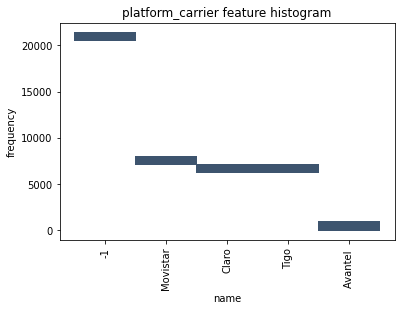

In [109]:
plot_feature_histogram(ctr_stats, ft_idx = 6)

Analisis de **app_bundle**

In [110]:
app_bundle_unique_val = len(ctr_schema.string_domain[6].value)
print('Valores unicos de {}: {}'.format(ctr_schema.string_domain[6].name, app_bundle_unique_val))

Valores unicos de app_bundle: 86


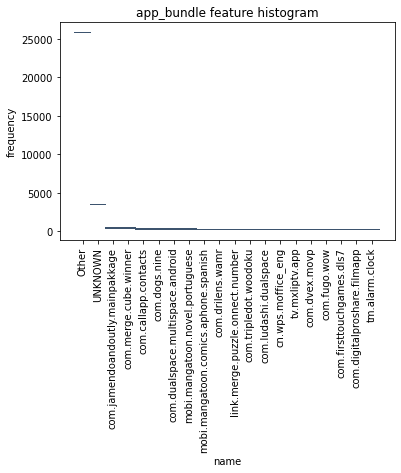

In [111]:
plot_feature_histogram(ctr_stats, ft_idx = 7)

Analisis de **domain**

In [112]:
domain_unique_val = len(ctr_schema.string_domain[7].value)
print('Valores unicos de {}: {}'.format(ctr_schema.string_domain[7].name,domain_unique_val))

Valores unicos de domain: 94


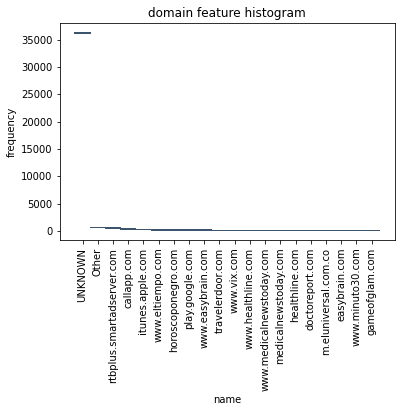

In [113]:
plot_feature_histogram(ctr_stats, ft_idx = 8)

## <font color='green'>Data Cleaning</font>

Teniendo en cuenta los argumentos presentados, se eliminan los features: 'plaform_carrier’, 'app_bundle', 'domain'.

In [115]:
ctr_cleaned_df = ctr_df.copy()

In [116]:
ctr_cleaned_df.drop(columns = ['platform_carrier', 'app_bundle', 'domain'], inplace=True)

In [117]:
# Perform removing of unknown values of rows
ctr_cleaned_df = delete_unknown_from_list(ctr_cleaned_df, 'ad_size', ['-1x-1', '1x1'])
ctr_cleaned_df = delete_unknown_from_list(ctr_cleaned_df, 'ad_position', ['POSITION_UNKNOWN', '0'])
ctr_cleaned_df = delete_unknown_from_list(ctr_cleaned_df, 'platform_bandwidth', ['CONNECTION_UNKNOWN', 'CELL_UNKNOWN', 'UNKNOWN'])
ctr_cleaned_df = delete_unknown_from_list(ctr_cleaned_df, 'environment_type', ['UNKNOWN'])

In [118]:
ctr_cleaned_df.reset_index(drop=True, inplace=True)
ctr_cleaned_df.head()

,ad_position,ad_size,hour_of_day_utc,inventory_source,platform_bandwidth,environment_type,ctr
0,FULLSCREEN,320x480,21,UNITY,WIFI,APP,0.206897
1,FULLSCREEN,320x480,23,UNITY,WIFI,APP,0.151163
2,FULLSCREEN,320x480,23,MOPUB,CELL_4G,APP,0.000000
3,FULLSCREEN,320x480,8,UNITY,WIFI,APP,0.047619
4,FULLSCREEN,480x320,9,UNITY,WIFI,APP,0.000000



Second inspection of data after cleaning.

In [119]:
ctr_cleaned_stats = tfdv.generate_statistics_from_dataframe(ctr_cleaned_df)

# Visualization of Raw Data
tfdv.visualize_statistics(ctr_cleaned_stats)

In [120]:
# Schema
ctr_cleaned_schema = tfdv.infer_schema(statistics=ctr_cleaned_stats)
tfdv.display_schema(ctr_cleaned_schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'ad_position',STRING,required,,'ad_position'
'ad_size',STRING,required,,'ad_size'
'hour_of_day_utc',INT,required,,-
'inventory_source',STRING,required,,'inventory_source'
'platform_bandwidth',STRING,required,,'platform_bandwidth'
'environment_type',STRING,required,,'environment_type'
'ctr',FLOAT,required,,-


,Values
Domain,
'ad_position',"'ABOVE_THE_FOLD', 'FOOTER', 'FULLSCREEN', 'HEADER'"
'ad_size',"'300x250', '300x50', '320x480', '320x50', '480x320', '768x1024'"
'inventory_source',"'INMOBI', 'INNERACTIVE', 'MILLENNIAL', 'MOPUB', 'RUBICON', 'SMARTADSERVER', 'UNITY', 'VERVE'"
'platform_bandwidth',"'CELL_2G', 'CELL_3G', 'CELL_4G', 'ETHERNET', 'WIFI'"
'environment_type','APP'


## <font color='green'>Data Preprocessing</font>

Label Encoding of categorical features

In [463]:
ctr_encoded_df = ctr_cleaned_df.copy()

# Label Encoding ad_position
label_encoder_ap = LabelEncoder()
ctr_encoded_df['ad_position'] = label_encoder_ap.fit_transform(ctr_cleaned_df['ad_position'])

# Label Encoding ad_size
label_encoder_as = LabelEncoder()
ctr_encoded_df['ad_size'] = label_encoder_as.fit_transform(ctr_cleaned_df['ad_size'])

# Label Encoding inventory_source
label_encoder_is = LabelEncoder()
ctr_encoded_df['inventory_source'] = label_encoder_is.fit_transform(ctr_cleaned_df['inventory_source'])

# Label Encoding platform_bandwidth
label_encoder_pb = LabelEncoder()
ctr_encoded_df['platform_bandwidth'] = label_encoder_pb.fit_transform(ctr_cleaned_df['platform_bandwidth'])

# Label Encoding environment_type
label_encoder_et = LabelEncoder()
ctr_encoded_df['environment_type'] = label_encoder_et.fit_transform(ctr_cleaned_df['environment_type'])

In [122]:
ctr_encoded_df.head()

,ad_position,ad_size,hour_of_day_utc,inventory_source,platform_bandwidth,environment_type,ctr
0,2,2,21,6,4,0,0.206897
1,2,2,23,6,4,0,0.151163
2,2,2,23,3,2,0,0.000000
3,2,2,8,6,4,0,0.047619
4,2,4,9,6,4,0,0.000000


Train-Test-Val sets Split

In [464]:
X_train, y_train, X_test, X_val, y_test, y_val = train_test_val_split(ctr_encoded_df, train_frac = 0.8)
print('Training set shape: {},\nTesting set shape: {},\nValidation set shape: {}'.format(X_train.shape, X_test.shape, X_val.shape))

Training set shape: (22966, 6),
Testing set shape: (2871, 6),
Validation set shape: (2871, 6)


Plotting of the different datasets to ensure that they were well distributed among the CTR score domain

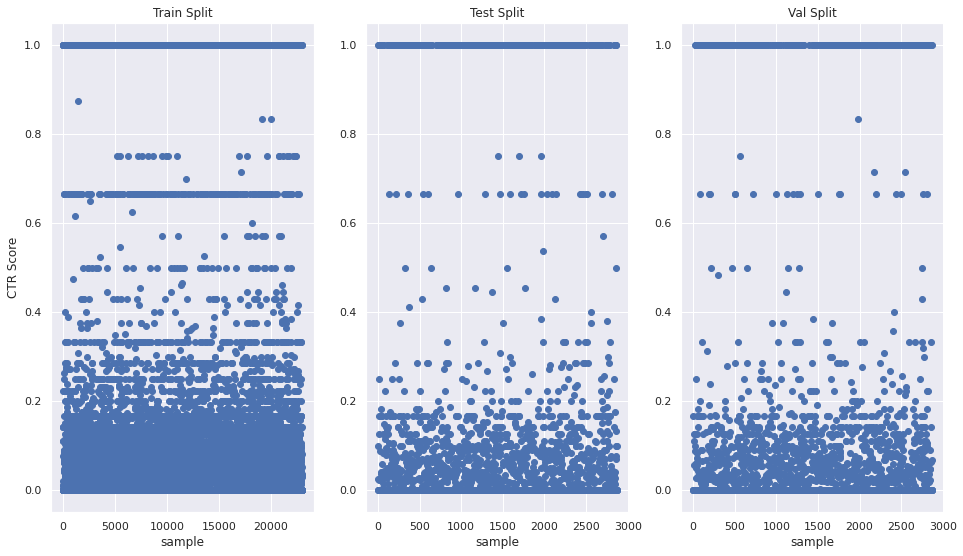

In [423]:
f, ax = plt.subplots(figsize=(16, 9))
plt.subplot(131), plt.title('Train Split'), plt.xlabel('sample'), plt.ylabel('CTR Score')
x_train = np.arange(0,len(X_train), 1)
plt.scatter(x_train, y_train)

plt.subplot(132), plt.title('Test Split'), plt.xlabel('sample')
x_test = np.arange(0,len(X_test), 1)
plt.scatter(x_test, y_test)

plt.subplot(133), plt.title('Val Split'), plt.xlabel('sample')
x_val = np.arange(0,len(X_val), 1)
plt.scatter(x_val, y_val)

# <font color='orange'>Training</font>

In [291]:
# DF to store metrics
results_df = pd.DataFrame(columns = ['model', 'mse', 'mae', 'r2'])

## <font color='green'>Training Helper Functions</font>

In [297]:
def get_results(regressor, X_val, y_val, name):
  '''
  Function to plot and get model performance over val set
  -----
  Args:
      regressor: Regressor model
      X_val: matrix that contains val features.
      y_val: Ground thruth with validation data.
      name: String to use as title when plotting.
  -----
  Return:
      results_dict: Dictionary with all metrics with the folliwing structure:
      {
        'mse': ,
        'mae': ,
        'r2':
      }
  '''

  # Len of validation data
  x_axis = np.arange(0, len(X_val), 1)
  # Preictions
  y_true = y_val
  y_pred = regressor.predict(X_val)

  # Plotting
  plt.subplots(figsize=(12,9))
  plt.scatter(x_axis, y_true, label = 'y_true')
  plt.scatter(x_axis, y_pred, label = 'y_pred')
  plt.title('Results '+ name), plt.xlabel('Sample'), plt.ylabel('CTR Score')
  plt.legend()

  # Obtaining results
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2  = r2_score(y_true, y_pred)

  results_dict = {'mse': mse,
                  'mae': mae,
                  'r2': r2}

  return results_dict

In [287]:
def add_result_df(results_df, results_dict, name):
  '''
  Funtion that adds results to summay dataframe
  ----
  Args:
       results_df: Summary dataframe containing model metrics.
       results_dict: Dictionary of results returend from `get_results` function.
       name: modelname to add in the summary dataframe.
  ----
  Return:
       results_df: Same summary dataframe with appended new values.
  '''
  
  results_df = results_df.append({'model': name,
                                  'mse': results_dict['mse'],
                                  'mae': results_dict['mae'],
                                  'r2':  results_dict['r2']}, ignore_index=True)
  
  return results_df

In [483]:
def plot_final_metrics(regressor, X_test, y_test, df, plot_title):
  '''
  Plotting metrics from best models
  ----
  Args:
       regressor: Regressor model object used
       X_test, y_test
       df: DataFrame used to split data
       plot_title
  '''
  y_pred = regressor.predict(X_test)
  performance_df = pd.DataFrame(columns = ['y_pred', 'y_true'])
  performance_df['y_pred'] = y_pred
  performance_df['y_true'] = y_test

  # Plot y_pred vs y_true
  plt.subplots(figsize=(12,9))
  sns.scatterplot(data = performance_df, x='y_true', y='y_pred')
  plt.title('y_pred vs y_true')

  # Plot Feature Importance
  features = list(df.columns[:-1])
  importances = regressor.feature_importances_
  FI_df = pd.DataFrame(columns=['features', 'importances'])
  FI_df['features'] = features
  FI_df['importances'] = importances


  _ = FI_df.plot(kind = 'bar')
  x = np.arange(0,len(features),1)
  plt.xticks(x,labels=features)
  plt.ylabel('Importance')
  plt.title(plot_title)


## <font color='green'>Decision Tree Classifier</font>

In [250]:
# Initialize decision tree regressor
regressor_dt = DecisionTreeRegressor(criterion='squared_error')
regressor_dt.fit(X_train, y_train)

DecisionTreeRegressor()

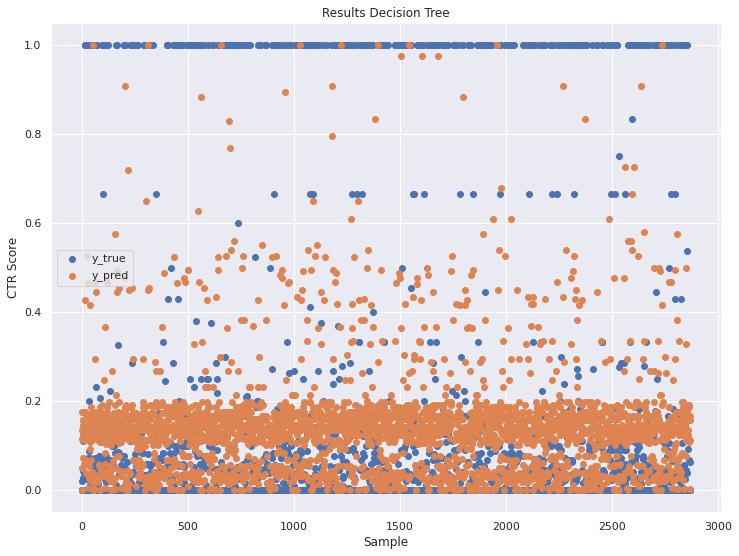

In [298]:
# Get Decision tree results
decision_tree_metrics = get_results(regressor_dt, X_val, y_val, name = 'Decision Tree')

In [292]:
# Append decision tree results to summary df
results_df = add_result_df(results_df, decision_tree_metrics, 'decision_tree')
results_df

,model,mse,mae,r2
0,decision_tree,0.080045,0.175937,0.176982


## <font color='green'>Random Forest Classifier</font>

In [196]:
# Initialize random forest regressor
rf_regressor = RandomForestRegressor(n_estimators = 100)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

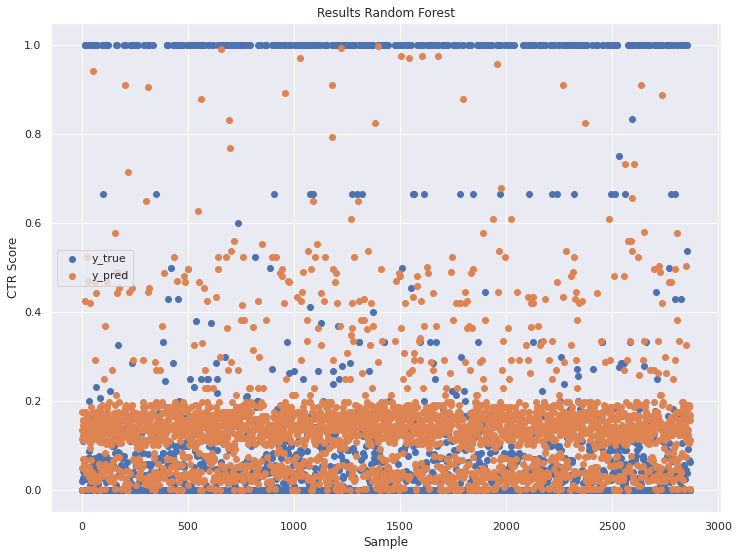

In [299]:
# Get random forest results
random_forest_metrics = get_results(rf_regressor, X_val, y_val, name = 'Random Forest')

In [294]:
# Append random forest results to summary df
results_df = add_result_df(results_df, random_forest_metrics, 'random_forest')
results_df

,model,mse,mae,r2
0,decision_tree,0.080045,0.175937,0.176982
1,random_forest,0.080011,0.176183,0.177332


## <font color='green'>SVR</font>

In [199]:
# Initialize SVR regressor
svr_regressor = SVR(C=1.0, epsilon=0.2)
svr_regressor.fit(X_train, y_train)

SVR(epsilon=0.2)

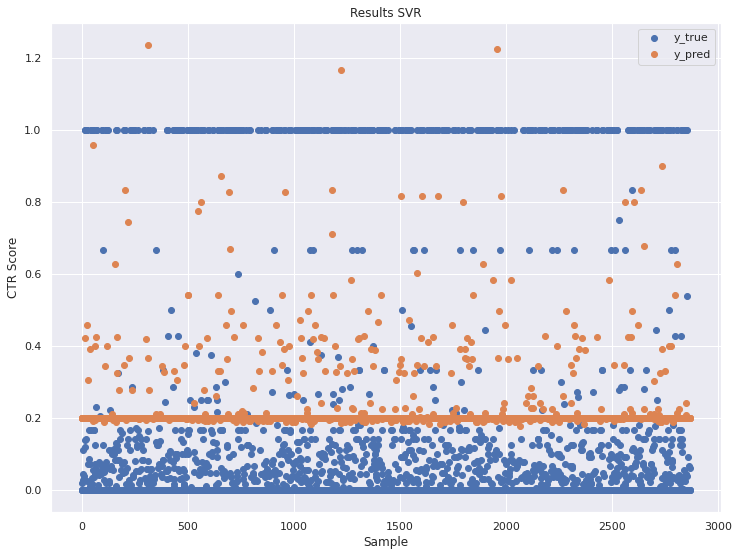

In [300]:
# Get SVR results
svr_metrics = get_results(svr_regressor, X_val, y_val, name = 'SVR')

In [296]:
# Append SVR results to summary df
results_df = add_result_df(results_df, svr_metrics, 'svr')
results_df

,model,mse,mae,r2
0,decision_tree,0.080045,0.175937,0.176982
1,random_forest,0.080011,0.176183,0.177332
2,svr,0.091327,0.237525,0.060980


## <font color='green'>Gradient Boosting</font>

In [204]:
# Initialize Gradient boosting regressor
gb_regressor = GradientBoostingRegressor(random_state=0)
gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

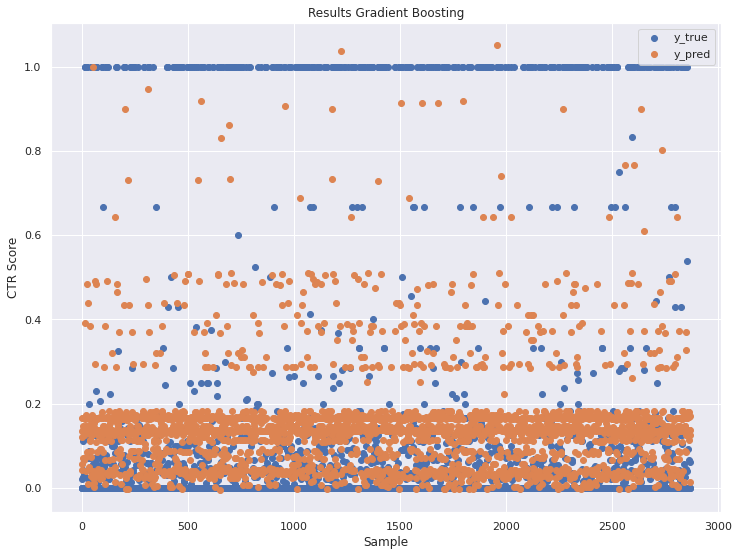

In [301]:
# Get Gradient Boosting results
gradient_metrics = get_results(gb_regressor, X_val, y_val, name = 'Gradient Boosting')

In [ ]:
# Append gradient boosting results to summary df
results_df = add_result_df(results_df, gradient_metrics, 'gradient_boosting')
results_df

In [303]:
results_df.to_excel('results_full_training.xlsx')

# <font color='orange'>Training Fine Tuning</font>

In [307]:
results_df_fine_tuning = pd.DataFrame(columns = ['model', 'mse', 'mae', 'r2'])

## <font color='green'>Decision Tree</font>

In [ ]:
# Hyperparameters Decision Tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']

randomGrid_dt = {'criterion': criterion,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth
              }

regressor_dt = DecisionTreeRegressor(criterion='squared_error')
decision_t_random = RandomizedSearchCV(estimator = regressor_dt, param_distributions=randomGrid_dt,
                    n_iter = 100, verbose = 2)

decision_t_random.fit(X_train, y_train)

In [309]:
decision_t_random.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=70,
                      min_samples_leaf=4)

Training using best estimator found

In [314]:
regressor_dt = DecisionTreeRegressor(criterion='friedman_mse', max_depth=70, min_samples_leaf=4)
regressor_dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=70,
                      min_samples_leaf=4)

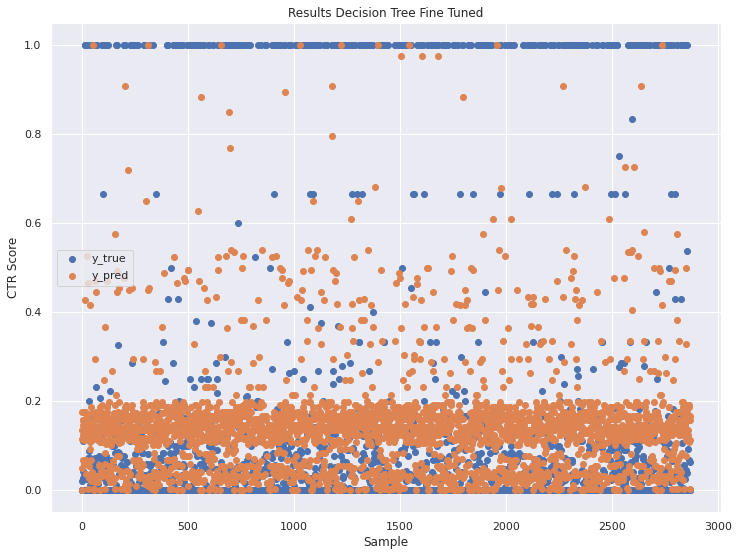

In [315]:
decision_tree_ft_metrics = get_results(regressor_dt, X_val, y_val, name = 'Decision Tree Fine Tuned')

In [317]:
results_df = add_result_df(results_df, decision_tree_ft_metrics, 'ft_fine_tuned')

In [318]:
results_df

,model,mse,mae,r2
0,decision_tree,0.080045,0.175937,0.176982
1,random_forest,0.080011,0.176183,0.177332
2,svr,0.091327,0.237525,0.060980
3,gradient_boosting,0.079365,0.176610,0.183975
4,dt_fine_tuned,0.079779,0.175736,0.179718


In [ ]:
results_df.to_excel('results_full_training.xlsx')

## <font color='green'>Gradient Boosting</font>

In [ ]:
# Hyperparameters Gradient Boosting
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
learning_rate = [x for x in np.linspace(1e-5, 1e-2, num = 11)]
n_estimators = [int(x) for x in np.linspace(200, 2000, 5)]

randomGrid_gb = {'loss': loss,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators
              }
            
gb_regressor = GradientBoostingRegressor()

gb_regressor_random = RandomizedSearchCV(estimator = gb_regressor, param_distributions=randomGrid_gb,
                               n_iter = 50, verbose = 2)

gb_regressor_random.fit(X_train, y_train)

In [327]:
gb_regressor_random.best_estimator_

GradientBoostingRegressor(learning_rate=0.004006, n_estimators=1550)

In [328]:
gb_regressor = GradientBoostingRegressor(learning_rate = 0.004006,
                                         n_estimators = 1550)
gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.004006, n_estimators=1550)

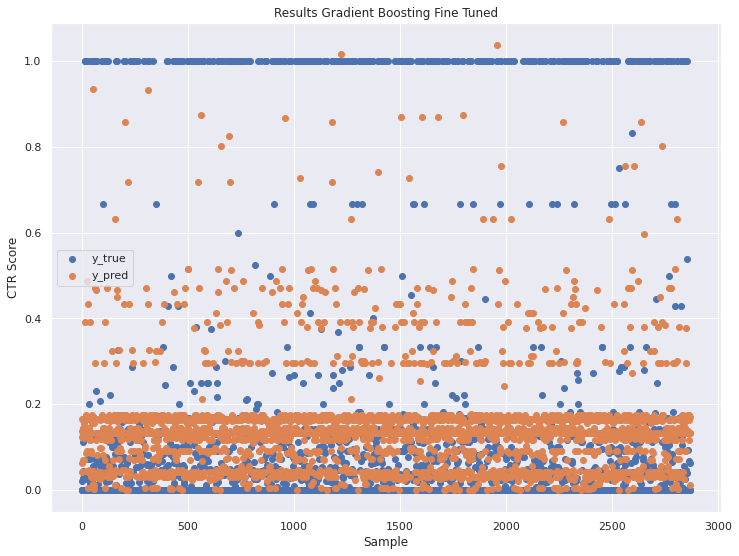

In [329]:
gradient_ft_metrics = get_results(gb_regressor, X_val, y_val, name = 'Gradient Boosting Fine Tuned')

In [330]:
results_df = add_result_df(results_df, gradient_ft_metrics, 'ft_gradient_boosting')
results_df

,model,mse,mae,r2
0,decision_tree,0.080045,0.175937,0.176982
1,random_forest,0.080011,0.176183,0.177332
2,svr,0.091327,0.237525,0.060980
3,gradient_boosting,0.079365,0.176610,0.183975
4,dt_fine_tuned,0.079779,0.175736,0.179718
5,ft_gradient_boosting,0.079413,0.177140,0.183482


# <font color='orange'>Best Model</font>

According to the summary df, the best model found is `gradient_boosting` with default parameters:
* loss: squared error
* learning rate (lr): 0.1
* number of estimators: 100

The decision was made knowing that mse and mae metrics should be minimized, and r2 maximized.

In [343]:
gb_regressor = GradientBoostingRegressor(random_state=0)
gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

Evaluating on test set

{'mae': 0.18136434827651438,
 'mse': 0.08380542018973951,
 'r2': 0.16269729994182014}

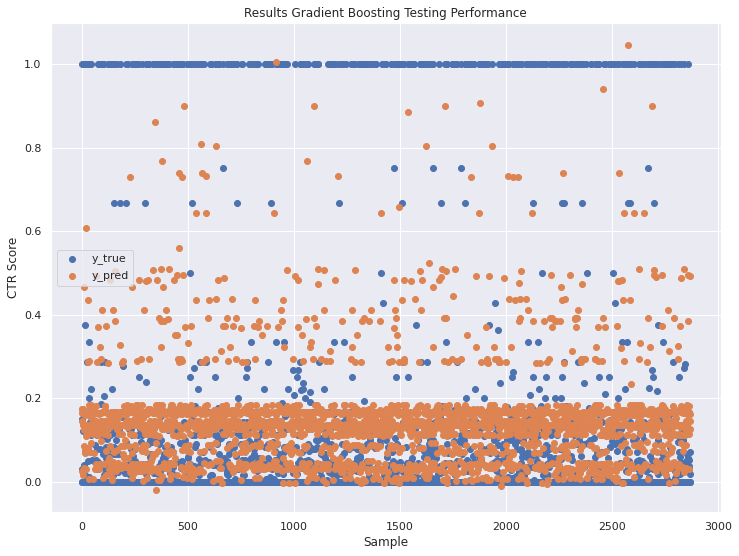

In [349]:
gradient_test_metrics = get_results(gb_regressor, X_test, y_test, name = 'Gradient Boosting Testing Performance')
gradient_test_metrics

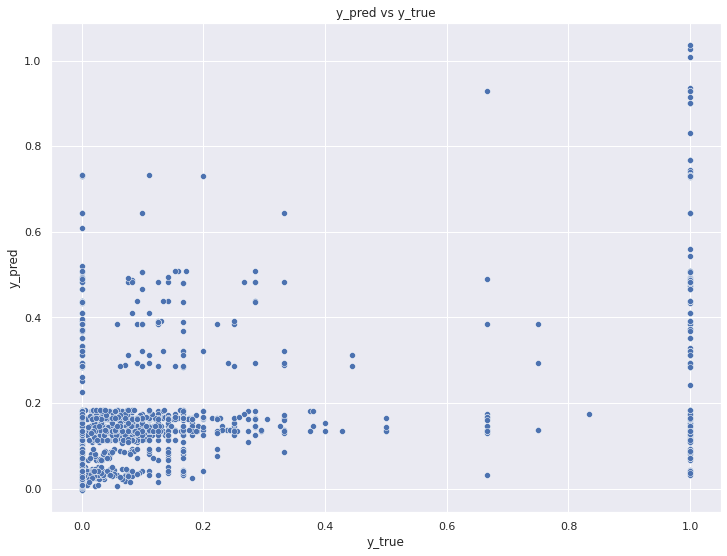

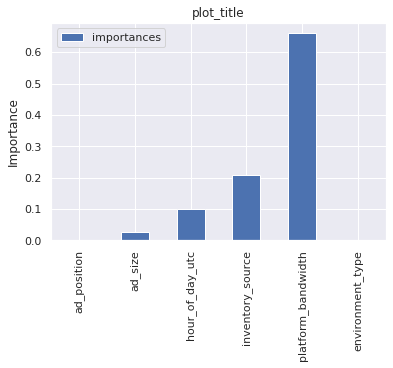

In [484]:
plot_final_metrics(gb_regressor, X_test, y_test, ctr_cleaned_df, 'plot_title')

# <font color='orange'>Best model with noisy data</font>

Usage of all of the data and even encoding unknown values

In [445]:
ctr_noisy_df = ctr_df.copy()
ctr_noisy_df.head()

,ad_position,ad_size,hour_of_day_utc,inventory_source,platform_bandwidth,environment_type,platform_carrier,app_bundle,domain,ctr
0,FULLSCREEN,320x480,21,UNITY,WIFI,APP,-1,Other,UNKNOWN,0.206897
1,FULLSCREEN,320x480,23,UNITY,WIFI,APP,-1,com.wordgame.puzzle.board.es,UNKNOWN,0.151163
2,0,320x480,23,OPERA_MEDIA,CELL_3G,APP,Claro,com.jamendoandoutly.mainpakkage,UNKNOWN,0.000000
3,FULLSCREEN,320x480,23,MOPUB,CELL_4G,APP,Movistar,com.drilens.wamr,UNKNOWN,0.000000
4,0,320x480,5,OPERA_MEDIA,WIFI,APP,Movistar,com.jam.endo,UNKNOWN,0.000000


**Label Encoding**

In [446]:
ctr_noisy_df['ad_position'] = LabelEncoder().fit_transform(ctr_df['ad_position'])
ctr_noisy_df['ad_size'] = LabelEncoder().fit_transform(ctr_df['ad_size'])
ctr_noisy_df['inventory_source'] = LabelEncoder().fit_transform(ctr_df['inventory_source'])
ctr_noisy_df['platform_bandwidth'] = LabelEncoder().fit_transform(ctr_df['platform_bandwidth'])
ctr_noisy_df['environment_type'] = LabelEncoder().fit_transform(ctr_df['environment_type'])
ctr_noisy_df['platform_carrier'] = LabelEncoder().fit_transform(ctr_df['platform_carrier'])
ctr_noisy_df['app_bundle'] = LabelEncoder().fit_transform(ctr_df['app_bundle'])
ctr_noisy_df['domain'] = LabelEncoder().fit_transform(ctr_df['domain'])

**Train-Test-Val Sets Split**

In [447]:
X_train_n, y_train_n, X_test_n, X_val_n, y_test_n, y_val_n = train_test_val_split(ctr_noisy_df, train_frac = 0.8)
print('Training set shape: {},\nTesting set shape: {},\nValidation set shape: {}'.format(X_train_n.shape, X_test_n.shape, X_val_n.shape))

Training set shape: (33081, 9),
Testing set shape: (4135, 9),
Validation set shape: (4136, 9)


In [449]:
gb_regressor_noisy = GradientBoostingRegressor(random_state=0)
gb_regressor_noisy.fit(X_train_n, y_train_n)

GradientBoostingRegressor(random_state=0)

{'mae': 0.13914662884132198,
 'mse': 0.059647157221454195,
 'r2': 0.2754951529125097}

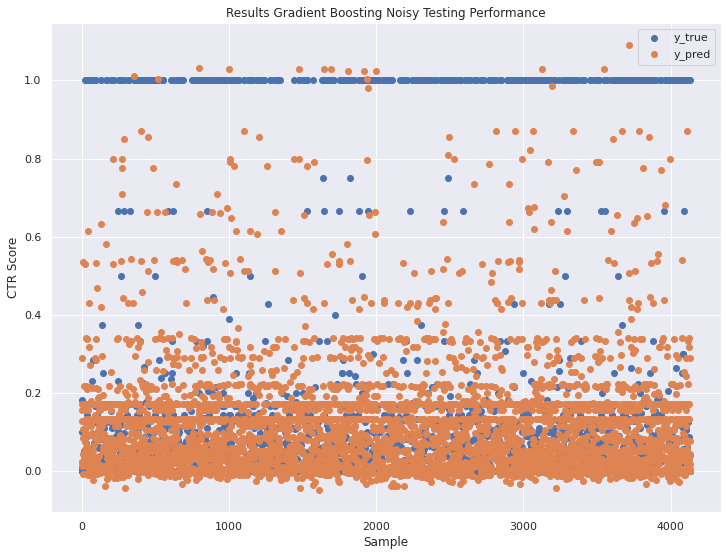

In [450]:
gradient_noisy_metrics = get_results(gb_regressor_noisy, X_test_n, y_test_n, name = 'Gradient Boosting Noisy Testing Performance')
gradient_noisy_metrics

In [468]:
results_df = add_result_df(results_df, gradient_noisy_metrics, 'noisy_gradient_boosting')
results_df

,model,mse,mae,r2
0,decision_tree,0.080045,0.175937,0.176982
1,random_forest,0.080011,0.176183,0.177332
2,svr,0.091327,0.237525,0.060980
3,gradient_boosting,0.079365,0.176610,0.183975
4,dt_fine_tuned,0.079779,0.175736,0.179718
5,ft_gradient_boosting,0.079413,0.177140,0.183482
6,noisy_gradient_boosting,0.059647,0.139147,0.275495


In [488]:
results_df.to_excel('results_full_training.xlsx')

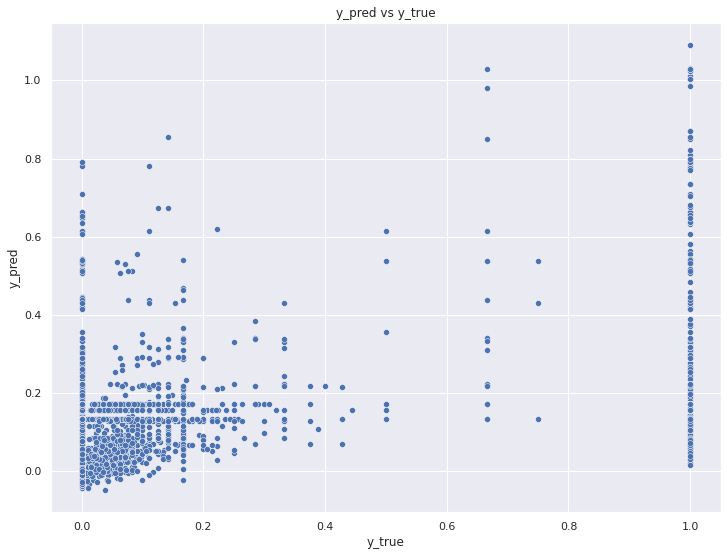

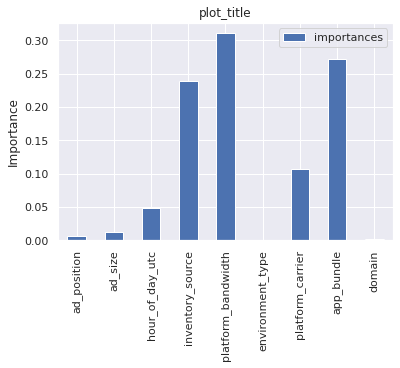

In [485]:
plot_final_metrics(gb_regressor_noisy, X_test_n, y_test_n, ctr_noisy_df, 'plot_title')